# Finger representations

Example of a fit of fixed and component pcm-models to data from M1. The models and data is taken from [Ejaz et al. (2015)](http://www.diedrichsenlab.org/pubs/Ejaz_NN_2015.pdf). *Hand usage predicts the structure of representations in sensorimotor cortex*, Nature Neuroscience.  

We will fit the following 5 models 

* null: G=np.eye, all finger patterns are equally far away from each other, Note that in many situations the no-information null model, G = np.zeros, maybe more appropriate   
* Muscle: Fixed model with G = covariance of muscle activities 
* Natural: Fixed model with G = covariance of natural movements
* Muscle+nat: Combination model of muscle and natural covariance 
* Noiseceil: Noise ceiling model 

In [1]:
# Import necessary libraries
import sys
from os.path import join, exists, abspath
from glob import glob

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dir_git = 'D:/mobaxterm/sungbeenpark/github'

In [3]:
path_module = abspath(join(dir_git,'PcmPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import PcmPy as pcm

added the path, D:\mobaxterm\sungbeenpark\github\PcmPy


Read in the activity Data (`Data`), condition vector (`cond_vec`), partition vector (`part_vec`), and model matrices for Muscle and Natural stats Models (`M`): 

In [4]:
f = open('data_demo_finger7T.p','rb')
Data, cond_vec, part_vec, modelM = pickle.load(f)
f.close()

$N=7$: The number of subjects

(40, 1946)
(35, 1657)
(35, 1681)
(35, 1736)
(40, 1589)
(40, 1722)
(40, 1702)


<Axes: >

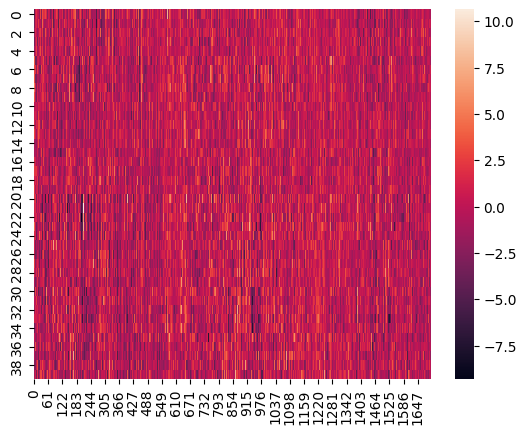

In [5]:
## array.shape = (n_condtion, n_voxels)
for array in Data:
    print(array.shape)
sns.heatmap(array)

(40,)
(35,)
(35,)
(35,)
(40,)
(40,)
(40,)


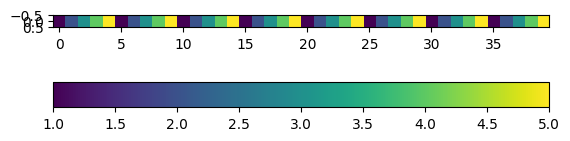

In [6]:
## array.shape = (n_condtion)
for array in cond_vec:
    print(array.shape)
plt.imshow(array[np.newaxis, :])
plt.colorbar(orientation='horizontal')

(40,)
(35,)
(35,)
(35,)
(40,)
(40,)
(40,)


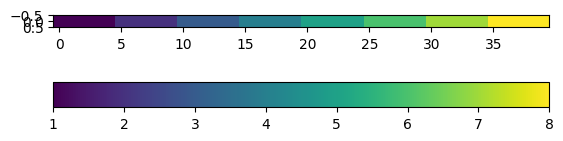

In [7]:
## array.shape = (n_condtion)
for array in part_vec:
    print(array.shape)
plt.imshow(array[np.newaxis, :])
plt.colorbar(orientation='horizontal')

(5, 5) 0.0
(5, 5) -2.220446049250313e-18


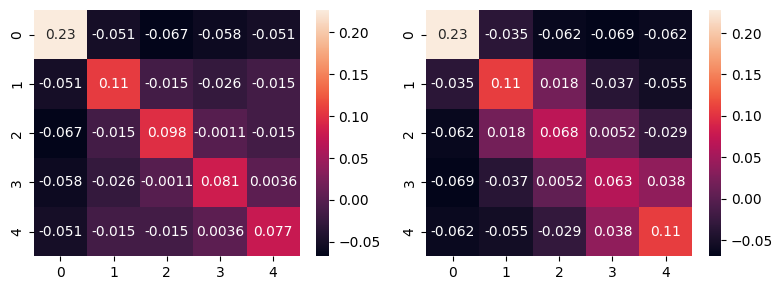

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3))
## array.shape = (n_conditions, n_conditions)
for ii, array in enumerate(modelM):
    ax = axs[ii]
    ## mean of array is 0
    print(array.shape, array.mean())
    sns.heatmap(array, annot=True, ax=ax)
fig.tight_layout()

Now we are build a list of datasets (one per subject) from the Data and condition vectors 

In [9]:
Y = list()
for subid in range(len(Data)):
    obs_des = {
        'cond_vec': cond_vec[subid],
        'part_vec': part_vec[subid]
    }
    Y.append(pcm.dataset.Dataset(Data[subid],obs_descriptors = obs_des))

## Inspect the data
Before fitting the models, it is very useful to first visualize the different data sets to see if there are outliers. One powerful way is to estimate a cross-validated estimate of the second moment matrix. This matrix is just another form of representing a cross-validated representational dissimilarity matrix (RDM).

$$
\text{Y}=\text{ZU}+\text{XB}+\epsilon
$$
where $\text{Y}$: 뇌 활동 데이터, $\text{U}$: 실질적인 활동 패턴, $\text{Z}$: 설계 행렬(design matrix), $\epsilon$: Gaussian noise

In [10]:
# Estimate and plot the second moment matrices across all data sets
N=len(Y)
G_hat = np.zeros((N,5,5))
for i in range(N):
    G_hat[i,:,:],_ = pcm.est_G_crossval(
        Y=Y[i].measurements,
        Z=Y[i].obs_descriptors['cond_vec'],
        part_vec=Y[i].obs_descriptors['part_vec'],
        X=pcm.matrix.indicator(Y[i].obs_descriptors['part_vec'])
    )

array([ 1.11022302e-18, -1.38777878e-19,  5.55111512e-19,  3.33066907e-18,
        5.55111512e-19,  8.32667268e-19,  1.11022302e-18])

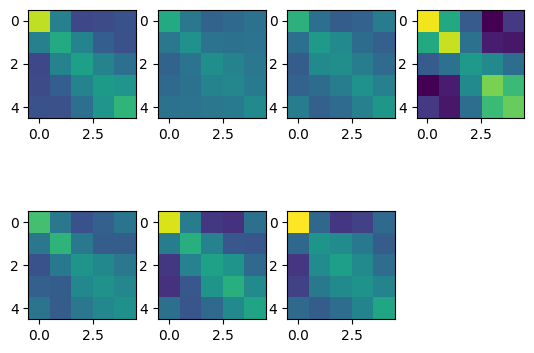

In [11]:
# show all second moment matrices G
## G.shape = (n_subject, 5, 5)
vmin = G_hat.min()
vmax = G_hat.max()
for i in range(N):
    plt.subplot(2,4,i+1)
    plt.imshow(G_hat[i,:,:],vmin=vmin,vmax=vmax)
## mean of each G_hat is 0
np.mean(G_hat, axis=(1,2))

Nice - up to a scaling factor (Subject 4 has especially high signal-to-noise) all seven subjects have a very similar structure of the reresentation of fingers in M1.  

If you are more used to looking in representational dissimilarity matrices (RDMs), you can also transform the second momement matrix into this (see Diedrichsen & Kriegeskorte,2017)

$$
diag(\text{CGC}^{\text{T}}) \rightarrow RDM
$$

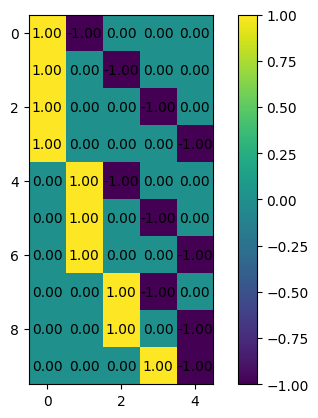

In [12]:
from scipy.spatial.distance import squareform

C = pcm.pairwise_contrast(np.arange(5))
plt.imshow(C)
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        text = plt.text(
            j, i, f"{C[i, j]:.2f}",
            ha="center", va="center", color="black"
        )
plt.colorbar()

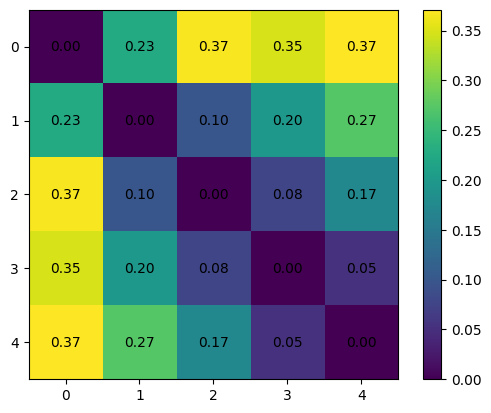

In [13]:
RDM = squareform(np.diag(C @ G_hat[0,:,:]@C.T))
plt.imshow(RDM)
for i in range(RDM.shape[0]):
    for j in range(RDM.shape[1]):
        text = plt.text(
            j, i, f"{RDM[i, j]:.2f}",
            ha="center", va="center", color="black"
        )
plt.colorbar()

## Build the models
Now we are building a list of models, using a list of second moment matrices

1. *Fixed models*: A fixed model pre-defines the structure of the data and evaluates how well the actual data matches this structure.
    - The null model is the simplest example, where G = 0. This assumes there are no differences in activity patterns between experimental conditions and is useful for testing whether any such differences exist.
    - In a fixed model, the second moment matrix (G) is precisely predicted by the model.
    - Fixed models are also used when the representational structure is predicted from independent data (e.g., predicting finger representation structure from the correlation of everyday finger movements).
    - Fixed models only predict the "shape" of G, not its overall scale. The scale can vary depending on the signal-to-noise ratio, so the predicted G is allowed to be multiplied by an arbitrary positive constant (e.g., exp(θs)) during evaluation.
    - Encoding models with a specific set of features are equivalent to fixed PCM models. In encoding analysis, estimating the ridge coefficient corresponds to determining the signal (θs) and noise (θε) parameters in PCM.

2. *Component models*: Component models provide a flexible framework for analyzing representational structures in neural data by expressing the second moment matrix as a weighted combination of predefined components.
    - Linear combination of components: The second moment matrix (G) is modeled as
    $$ G = \sum_{h}exp(\theta_{h})G_{h} $$
    where each $G_{h}$ represents a component matrix.
    - Positivity constraint: Weights for components $exp(\theta_{h})$ are forced to be positive to ensure the resulting matrix remains positive definite, a requirement for valid covariance structures

3. *Feature models*: Feature models analyze neural representations by modeling voxel activity as weighted combinations of hypothetical tuning functions (features).

    - Feature encoding: Voxel activity profiles $u_{p}$ are expressed as $u_{p}=\text{Mw}_{p}$, where $\text{M}$ is the feature matrix (e.g., Gabor filters for vision, cosine tuning for motor tasks) and $\text{w}_{p}$ is a feature weight on voxel $p$.
    - Second moment matrix: Under the assumption $E(\text{w}_{p}\text{w}^{T}_{p})=\text{I}$, the second moment matrix becomes $G=\text{MM}^{T}$, capturing covariance across features.
    - Parametrization: The feature matrix $\text{M}$ is a weighted sum of components:
      $$\text{M}=\sum_{h}\theta_{h}\text{M}_{h}$$
      Here, $\theta_{h}$ determines the strength of each feature component.
    - Resulting structure: The second moment matrix becomes:
      $$G=\frac{1}{P}\sum_{h}\theta^{2}_{h}\text{M}_{h}\text{M}_{h}^{T}+\sum_{i, j}\theta_{i}\theta_{j}\text{M}_{i}\text{M}_{j}^{T}$$
      This formulation accounts for interactions between non-independent features.
    - Component models assume feature independence ($\text{M}_{i}\text{M}_{j}^{T}=0$). simplifying $G$ to $\sum_{h}exp(\theta_{h})\text{M}_{h}\text{M}_{h}^{T}$. Feature models relax this, allowing interactions.
    - Parameter constraints: Feature models use $\theta_{h}^{2}$ (non-negative), while component models use $exp(\theta_{h})$.

4. *Free models*: Free models provide maximum flexibility in representational analysis by estimating the second moment matrix ($G$) without constraints.

    - Unconstrained estimation: $G$ is derived via maximum-likelihood estimation, allowing it to adapt to data without predefined structure.
    - Positive definiteness: To ensure valid covariance properties, $G$ is expressed as $G=AA^{T}$, where $A$ is an upper-triangular matrix. Parameters ($\theta_{m}$) correspond to $A$'s upper-triangular entries.
    - Noise ceiling estimation: Serves as a benchmark to evaluate how well other models could potentially fit the data.
    - Corrected pattern correlation: Reduces noise bias in correlation estimates between activity patterns compared to raw correlations.

In [14]:
# Make an empty list
M = []
# Null model: All fingers are represented independently. 
# For RSA model that would mean that all distances are equivalent
M.append(pcm.FixedModel('null',np.eye(5)))
# Muscle model: Structure is given by covariance structure of EMG signals
M.append(pcm.FixedModel('muscle',modelM[0]))
# Usage model: Structure is given by covariance structure of EMG signals
M.append(pcm.FixedModel('usage',modelM[1]))
# Component model: Linear combination of the muscle and usage model
M.append(pcm.ComponentModel('muscle+usage',[modelM[0],modelM[1]]))
# Free noise ceiling model
M.append(pcm.FreeModel('ceil',5)) # Noise ceiling model 

Now let's look at two underlying second moment matrices - these are pretty similar

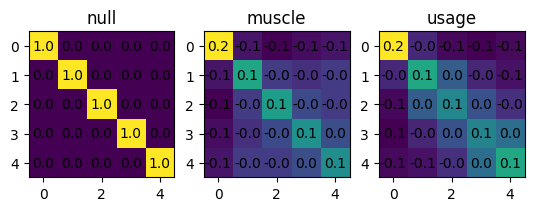

In [15]:
for i in range(3):
    mat = M[i].G
    name = M[i].name
    plt.subplot(1,3,i+1)
    for j in range(mat.shape[0]):
        for k in range(mat.shape[1]):
            text = plt.text(
                k, j, f"{mat[j, k]:.1f}",
                ha="center", va="center", color="black"
            )
    plt.imshow(mat)
    plt.title(name)

## Model fitting
Now let's fit the models to individual data set. There are three ways to do this. We can fit the models

* to each individual participant with it's own parameters $\theta$
* to each all participants together with shared parameters, but with an individual parameter for the signal strength and for group. 
* in a cross-participant crossvalidated fashion. The models are fit to N-1 subjects and evaluated on the Nth subject. 



In [16]:
# Do the individual fits - suppress verbose printout
T_in, theta_in = pcm.fit_model_individ(Y,M,fit_scale = True, verbose = False) 

In [17]:
# Fit the model in to the full group, using a individual scaling parameter for each 
T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)

Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4


In [18]:
# crossvalidated likelihood 
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4


## Inspecting and interpreting the results
The results are returned as a nested data frame with the likelihood, noise and scale parameter for each individuals

In [19]:
T_in

variable    likelihood                                            \
model             null        muscle         usage  muscle+usage   
0        -42231.412711 -41966.470799 -41786.672956 -41786.672927   
1        -34965.171104 -34923.791342 -34915.406608 -34914.959612   
2        -34767.538097 -34679.107626 -34632.643241 -34632.642946   
3        -45697.970627 -45609.052395 -45448.518276 -45448.518254   
4        -31993.363827 -31866.288313 -31806.982719 -31806.982521   
5        -41817.234010 -41632.061473 -41543.438786 -41543.438769   
6        -50336.142592 -50201.799362 -50173.300358 -50173.300306   

variable                   noise                                             \
model             ceil      null    muscle     usage muscle+usage      ceil   
0        -41689.860468  0.875853  0.871286  0.868482     0.868483  0.872297   
1        -34889.042772  1.070401  1.067480  1.069075     1.068119  1.066987   
2        -34571.750328  1.026408  1.021219  1.019122     1.019123  1.023312   
3        -45225.784824  1.480699  1.479592  1.474026     1.474025  1.478701   
4        -31707.184232  0.808482  0.805621  0.805774     0.805774  0.807319   
5        -41439.111952  1.035696  1.031827  1.031649     1.031648  1.034879   
6        -50099.140711  1.479001  1.472401  1.474430     1.474428  1.476146   

variable iterations                                     scale            \
model          null muscle usage muscle+usage  ceil      null    muscle   
0               4.0    4.0   4.0          7.0  30.0  0.109319  0.750145   
1               4.0    4.0   4.0         16.0  21.0  0.045008  0.324407   
2               4.0    4.0   4.0          7.0  36.0  0.059863  0.435484   
3               4.0    4.0   4.0          6.0  18.0  0.173031  1.193770   
4               4.0    4.0   4.0          6.0  32.0  0.073935  0.516338   
5               4.0    4.0   4.0          5.0  19.0  0.116696  0.801114   
6               4.0    4.0   4.0         12.0  31.0  0.101477  0.714043   

variable                                   
model        usage muscle+usage      ceil  
0         0.786771     1.000000  0.996688  
1         0.322917     0.961247  0.997908  
2         0.463987     1.000000  0.992282  
3         1.235628     1.000000  0.998173  
4         0.532421     1.000000  0.999362  
5         0.828773     1.000000  0.999324  
6         0.723969     1.000000  0.979400

The likelihoods are very negative and quite different across participants, which is expected (see documentation). What we need to interpret are the difference is the likelihood relative to a null model. 
We can visualized these using the model_plot

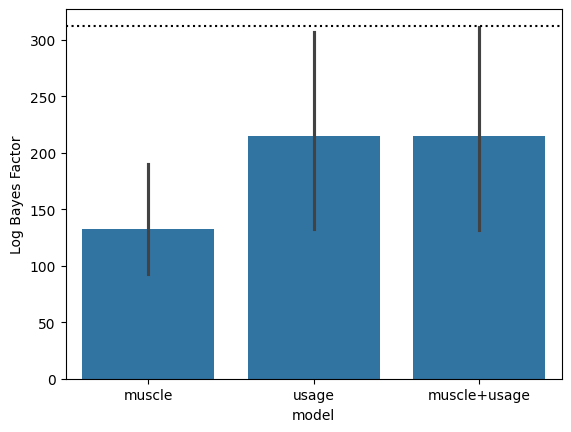

In [20]:
ax = pcm.model_plot(T_in.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil')

The problem with the noise ceiling is that it is individually fit to each subject. It has much more parameters than the models it is competing against, so it is overfitting. To compare models with different numbers of parameters directly, we need to look at our cross-validated group fits. The group fits can be used as an upper noise ceiling.

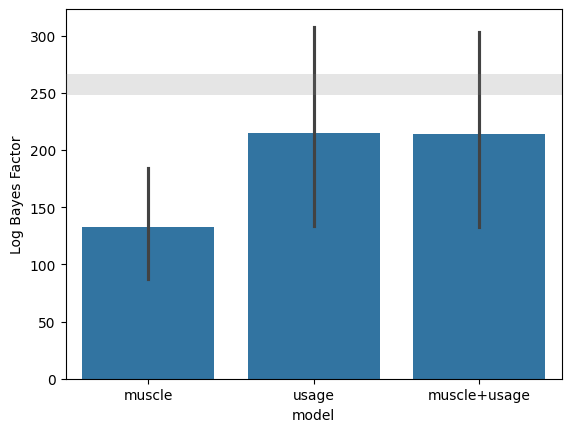

In [21]:
ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil',
                        upper_ceiling = T_gr.likelihood['ceil'])


As you can see, the likelihood for individual, group, and crossvalidated group fits for the fixed models (null, muscle + usage) are all identical, because these models do not have common group parameters - in all cases we are fitting an individual scale and noise parameter.

### Noise ceilings

Demonstrating that a model explains the data better than a simpler null model is an important step. Equally important, however, is determining how much of the data remains unexplained by the model. Noise ceilings (Nili et al., 2014) provide an estimate of how much systematic structure—either within or across participants—is present in the data, and what proportion is truly random.

In the context of Pattern Component Modeling (PCM), this can be assessed by fitting a fully flexible, or "free," model in which the second moment matrix can take any form. The non-cross-validated fit of this model serves as an absolute upper bound—no simpler model can achieve a higher average likelihood. However, this estimate is clearly inflated, as it does not account for overfitting due to parameter fitting. Therefore, we can also evaluate the free model using cross-validation.

Importantly, the same cross-validation strategy (within or between subjects) must be applied as with the models of interest. If the free model still outperforms the model of interest even when cross-validated, this indicates that there are aspects of the representational structure that the model fails to capture. Conversely, if the free model performs worse, it is overfitting the data, and the current best model provides a more concise description of the data. In this sense, the cross-validated performance of the free model provides a “lower bound” for the noise ceiling. There may still be a better model that could outperform the current best model, but at least the current model already offers an adequate description of the data.

Because noise ceilings are so informative, they should become a standard reporting requirement when fitting representational models to fMRI data, as is already the case in other areas of neuroscience. The null model and the upper noise ceiling also allow us to normalize the log model evidence between 0 (null model) and 1 (noise ceiling), effectively yielding a pseudo-R².

## Visualizing the model fit

Finally, it is very useful to visualize the model prediction in comparision to the fitted data. The model parameters are stored in the return argument `theta`. We can pass these to the `Model.predict()` function to get the predicted second moment matrix. 

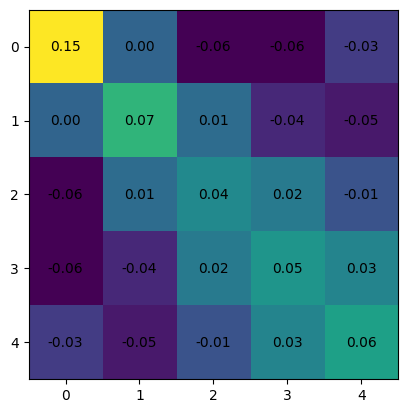

In [22]:
G,_ = M[4].predict(theta_gr[4][:M[4].n_param])
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        text = plt.text(
            j, i, f"{G[i, j]:.2f}",
            ha="center", va="center", color="black"
        )
plt.imshow(G)